In [1]:
import chromatix.functional as cf
import jax.numpy as jnp
from chromatix.utils.fft import fft, ifft
from jax import Array
from jax.lax import scan
from jax.typing import ArrayLike
from sample import paper_sample
from tensor_tomo import outer, matvec, eps
import matplotlib.pyplot as plt

from chromatix.utils import sigmoid_taper
%config InlineBackend.figure_format='retina'

In [2]:
# Our input field is a plane wave
shape = (220, 220) # field size
spacing = 0.065 # from paper
wavelength = 0.405 # from paper
nm = 1.33
polarisation = cf.linear(0) # x-polarised light

in_field = cf.plane_wave(shape, spacing, wavelength, 1.0, amplitude=polarisation, scalar=False, power=100)
# Using gaussian beam
in_field = in_field.replace(u=in_field.u * sigmoid_taper((220, 220), 5)) #jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 1.5**2)))) # gaussian 
#in_field = in_field.replace(u=in_field.u * jnp.sqrt(jnp.exp(-jnp.sum(in_field.grid**2, axis=0) / (2 * 4.0**2)))) # gaussian 

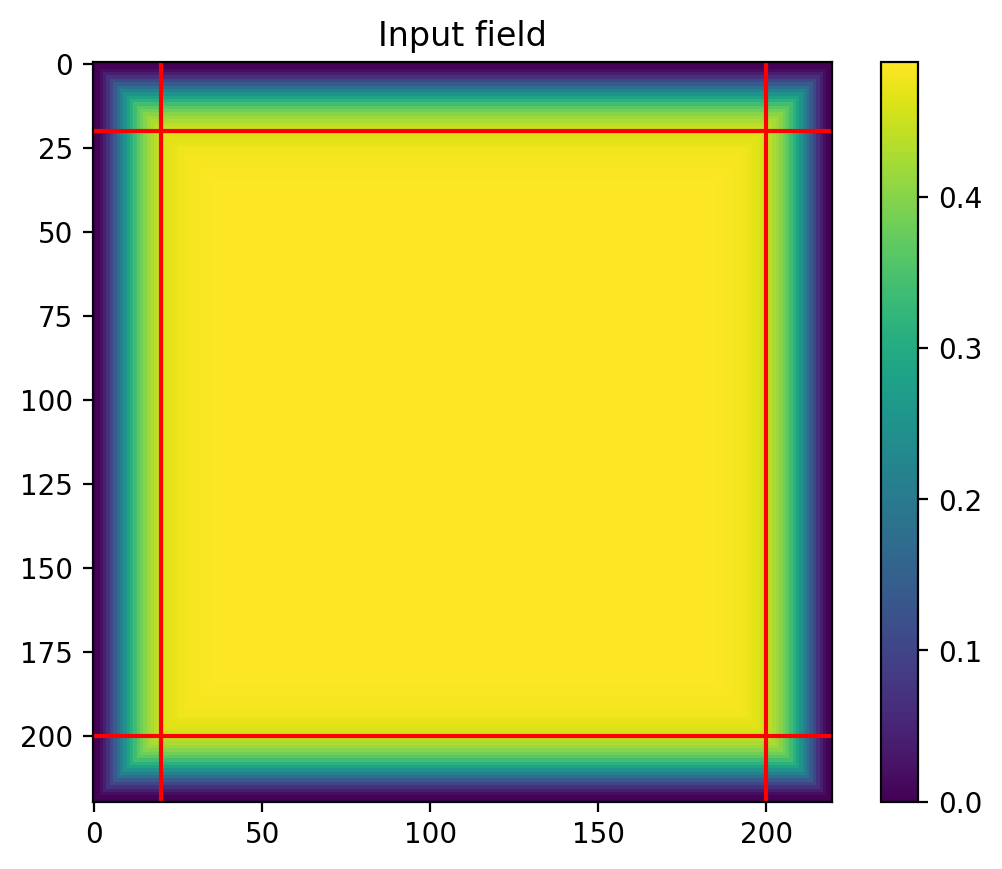

In [3]:
plt.title("Input field")
plt.axhline(20, color='r')
plt.axhline(200, color='r')
plt.axvline(20, color='r')
plt.axvline(200, color='r')
plt.imshow(in_field.intensity.squeeze())
plt.colorbar()

In [4]:
# Sample from the paper
sample = paper_sample()
print(f"Sample shape: {sample.shape}")


Sample shape: (70, 180, 180, 3, 3)


In [12]:
def thick_polarised_sample_evanescent(field: cf.VectorField, potential: ArrayLike, nm: ArrayLike, dz: ArrayLike) -> cf.VectorField:
    def Q_op(u: Array) -> Array:
        # correct
        """Polarisation transfer operator"""
        u = jnp.pad(u, padding)
        return ifft(matvec(Q, fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def H_op(u: Array) -> Array:
        # correct
        """Vectorial scattering operator"""
        u = jnp.pad(u, padding)
        prefactor = -1j / 2 * jnp.exp(1j * kz * dz) / kz * dz
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]
    
    def P_op(u: Array) -> Array:
        # correct
        """Vectorial free space operator"""
        u = jnp.pad(u, padding)
        prefactor =  jnp.exp(1j * kz * dz)
        return ifft(matvec(Q, prefactor * fft(u)))[:, n_pad[0]: -n_pad[0], n_pad[1]:-n_pad[1]]

    def propagate_slice(u: Array, potential_slice: Array) -> tuple[Array, None]:
        scatter_field = matvec(potential_slice, Q_op(u))
        return P_op(u) + H_op(scatter_field), None

   
    # We use z yx ordering, and add the 2pi factor to chromatix kgrrid
    # We chop off evanescent waves
    # NOTE: understand why we need nm here
    padded_shape = jnp.array(field.shape[1:3]) + jnp.array(potential.shape[1:3])
    n_pad = (padded_shape - jnp.array(field.shape[1:3])) // 2
    padding = ((0, 0), (n_pad[0], n_pad[0]), (n_pad[1], n_pad[1]), (0, 0), (0, 0))

    k_grid = 2 * jnp.pi * jnp.stack(jnp.meshgrid(jnp.fft.fftfreq(n=padded_shape[0], d=spacing), jnp.fft.fftfreq(n=padded_shape[1], d=spacing), indexing='ij'))[:, None, ..., None, None]
    km = 2 * jnp.pi * nm / field.spectrum
    kz = jnp.sqrt(km**2 - jnp.sum(k_grid**2, axis=0, dtype=jnp.complex64))
    k_grid =  jnp.concatenate([kz[None, ...], k_grid], axis=0)

    # Calculating PTFT
    Q = (-outer(k_grid / km, k_grid / km, in_axis=0) + jnp.eye(3)).squeeze(-3)

    # Running scan over sample
    u, _ = scan(propagate_slice, field.u, potential[..., None, :, :])
    return field.replace(u=u)

In [13]:
# Running the simulation
field = thick_polarised_sample_evanescent(in_field, sample, 1.33, 0.065)

# Making plotting a little easier
# ::-1 to invert y axis
amplitude = field.amplitude.squeeze()
amplitude = amplitude[::-1]

phase = field.phase.squeeze()
phase = phase[::-1]

ValueError: Incompatible shapes for matmul arguments: (180, 180, 1, 3, 3) and (1, 0, 0, 1, 3, 1)

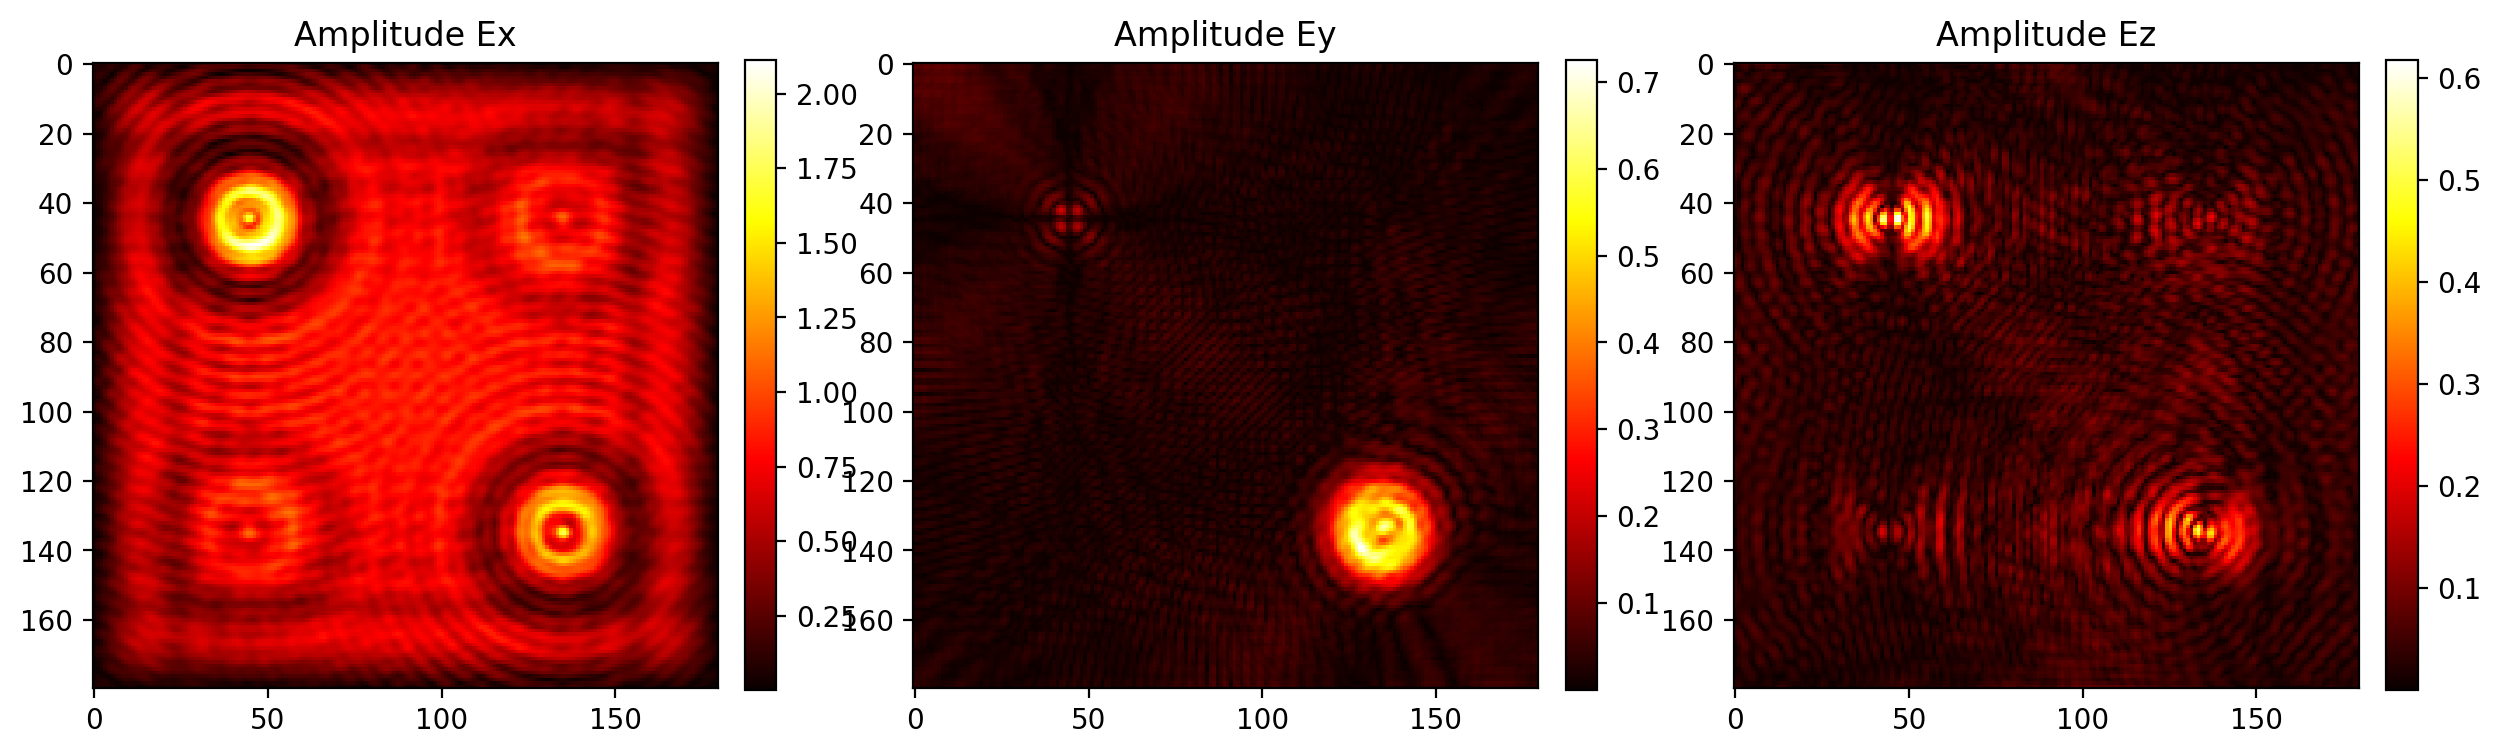

In [150]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Amplitude Ex")
plt.imshow(amplitude[..., 2], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Amplitude Ey")
plt.imshow(amplitude[..., 1], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Amplitude Ez")
plt.imshow(amplitude[..., 0], cmap="hot")
plt.colorbar(fraction=0.046, pad=0.04)

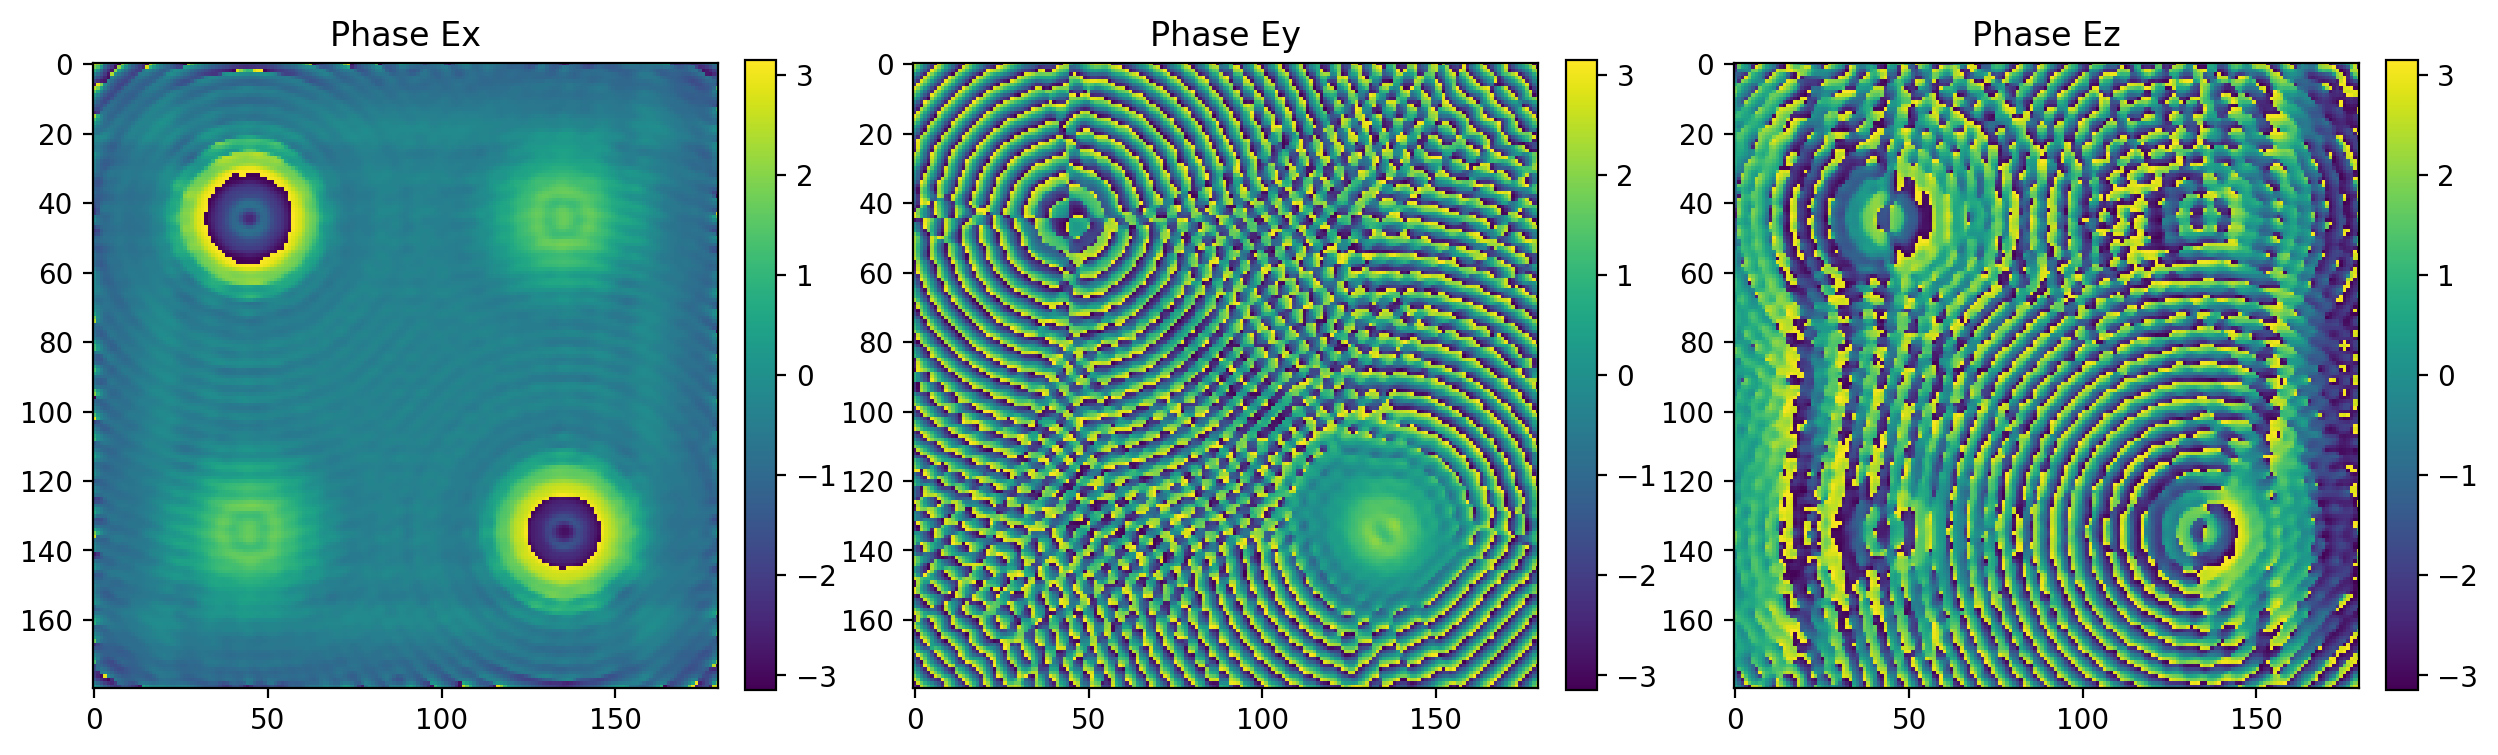

In [151]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title("Phase Ex")
plt.imshow(phase[..., 2])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.title("Phase Ey")
plt.imshow(phase[..., 1])
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.title("Phase Ez")
plt.imshow(phase[..., 0])
plt.colorbar(fraction=0.046, pad=0.04)

In [130]:
u = jnp.pad(in_field.u, ((0, 0), (90, 90), (90, 90), (0, 0), (0, 0)))

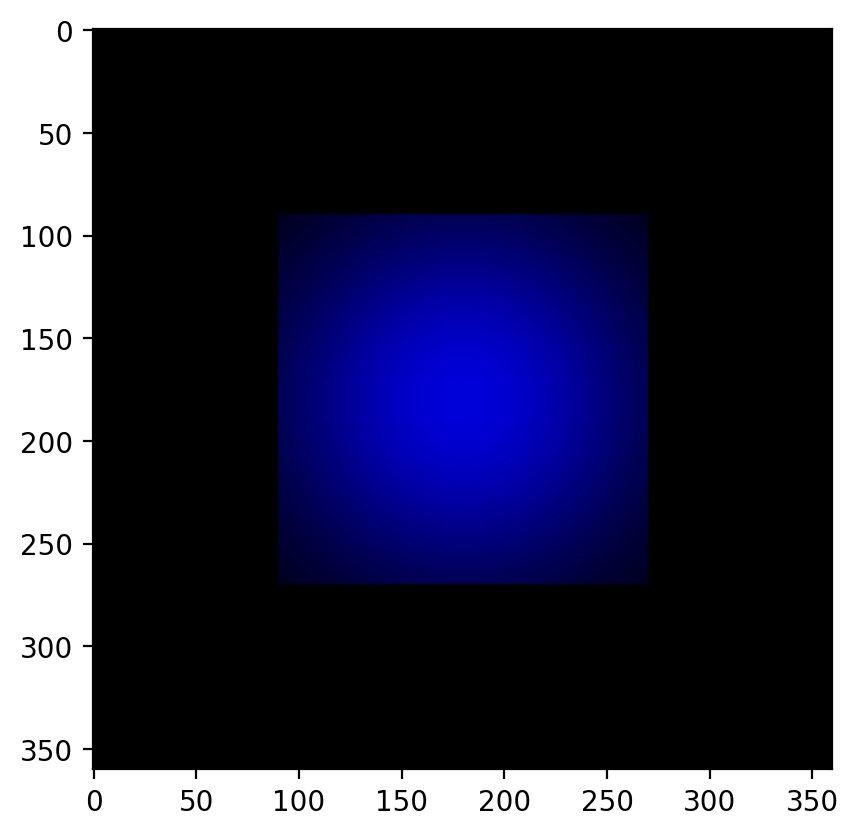

In [29]:
plt.imshow(u.real.squeeze())

In [70]:
3**2 / (0.065 * 0.405)

341.88034188034186

In [86]:
2 / wavelength

4.938271604938271

In [89]:
3 * 180 / (shape[0] * spacing)

46.153846153846146